In [1]:
import rasterio
import rasterio.features
import rasterio.warp
import geopyspark as gps
import numpy as np
import matplotlib.pyplot as plt

from pyspark import SparkContext
from geonotebook.wrappers import TMSRasterData
from osgeo import osr

%matplotlib inline

In [2]:
conf = gps.geopyspark_conf("yarn-client", "CDL Ingest")
conf.set("spark.dynamicAllocation.enabled", False)
conf.set("spark.hadoop.yarn.timeline-service.enabled", False)
#conf.set("spark.kryo.unsafe", True)
#conf.set("spark.rdd.compress", True)
conf.set("spark.yarn.executor.memoryOverhead", "3G")
conf.set("spark.yarn.driver.memoryOverhead", "3G")

In [3]:
sc = SparkContext(conf=conf)

In [4]:
uri = 's3://datahub-rawdata-us-east-1/cdl/CDLS_2016_30m.tif'
# uri = '/tmp/CDLS_2016_30m.tif'

In [5]:
def get_metadata(uri):
    
    try:
        with rasterio.open(uri) as dataset:
            bounds = dataset.bounds
            height = height = dataset.height
            width = dataset.width
            crs = dataset.get_crs()
            srs = osr.SpatialReference()
            srs.ImportFromWkt(crs.wkt)
            proj4 = srs.ExportToProj4()
            ws = [w for (ij, w) in dataset.block_windows()]
    except:
            ws = []
            
    def windows(uri, ws):
        for w in ws:
            ((row_start, row_stop), (col_start, col_stop)) = w

            left  = bounds.left + (bounds.right - bounds.left)*(float(col_start)/width)
            right = bounds.left + (bounds.right - bounds.left)*(float(col_stop)/ width)
            bottom = bounds.top + (bounds.bottom - bounds.top)*(float(row_stop)/height)
            top = bounds.top + (bounds.bottom - bounds.top)*(float(row_start)/height)
            extent = gps.Extent(left,bottom,right,top)
                
            new_line = {}
            new_line['uri'] = uri
            new_line['window'] = w
            new_line['projected_extent'] = gps.ProjectedExtent(extent=extent, proj4=proj4)
            yield new_line
    
    return [i for i in windows(uri, ws)]


In [6]:
rdd1 = sc.parallelize([uri]).flatMap(get_metadata)
rdd1.first()

{'projected_extent': ProjectedExtent(extent=Extent(xmin=-2356095.0, ymin=3141885.0, xmax=-2325375.0, ymax=3172605.0), epsg=None, proj4='+lat_0=23 +lat_1=29.5 +ellps=GRS80 +lat_2=45.5 +lon_0=-96 +no_defs +proj=aea +units=m +x_0=0 +towgs84=0,0,0,0,0,0,0 +y_0=0 +wktext'),
 'uri': 's3://datahub-rawdata-us-east-1/cdl/CDLS_2016_30m.tif',
 'window': ((0, 1024), (0, 1024))}

In [7]:
def get_data(line):
    
    new_line = line.copy()

    with rasterio.open(line['uri']) as dataset:
        new_line['data'] = dataset.read(1, window=line['window'])
        new_line.pop('window')
        new_line.pop('uri')
    
    return new_line

In [8]:
rdd2 = rdd1.map(get_data)
rdd2.first()

{'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'projected_extent': ProjectedExtent(extent=Extent(xmin=-2356095.0, ymin=3141885.0, xmax=-2325375.0, ymax=3172605.0), epsg=None, proj4='+lat_0=23 +lat_1=29.5 +ellps=GRS80 +lat_2=45.5 +lon_0=-96 +no_defs +proj=aea +units=m +x_0=0 +towgs84=0,0,0,0,0,0,0 +y_0=0 +wktext')}

In [9]:
rdd3 = rdd2.groupBy(lambda line: line['projected_extent']) # XXX
rdd3.first()

(ProjectedExtent(extent=Extent(xmin=-1495935.0, ymin=1360125.0000000002, xmax=-1465215.0, ymax=1390844.9999999998), epsg=None, proj4='+lat_0=23 +lat_1=29.5 +ellps=GRS80 +lat_2=45.5 +lon_0=-96 +no_defs +proj=aea +units=m +x_0=0 +towgs84=0,0,0,0,0,0,0 +y_0=0 +wktext'),
 <pyspark.resultiterable.ResultIterable at 0x7fd226aba2b0>)

In [10]:
def make_tiles(line):
    projected_extent = line[0]
    array = np.array([l['data'] for l in line[1]])
    tile = gps.Tile.from_numpy_array(array, no_data_value=0)
    return (projected_extent, tile)

def interesting_tile(line):
    [pe, tile] = line
    return (np.sum(tile[0][0]) != 0)

def square_tile(line):
    [pe, tile] = line
    return tile[0][0].shape == (1024,1024)

In [11]:
rdd4 = rdd3.map(make_tiles).filter(square_tile)
data = rdd4.filter(interesting_tile).first()
data

(ProjectedExtent(extent=Extent(xmin=1391745.0, ymin=1360125.0000000002, xmax=1422465.0000000005, ymax=1390844.9999999998), epsg=None, proj4='+lat_0=23 +lat_1=29.5 +ellps=GRS80 +lat_2=45.5 +lon_0=-96 +no_defs +proj=aea +units=m +x_0=0 +towgs84=0,0,0,0,0,0,0 +y_0=0 +wktext'),
 Tile(cells=array([[[142, 142, 142, ..., 142, 142, 176],
        [142, 142, 142, ..., 142, 142, 142],
        [142, 142, 142, ..., 152, 152, 142],
        ..., 
        [142, 142, 142, ..., 142, 190, 190],
        [142, 142, 142, ..., 142, 142, 190],
        [142, 142, 142, ..., 142, 142, 142]]], dtype=uint8), cell_type='UBYTE', no_data_value=0))

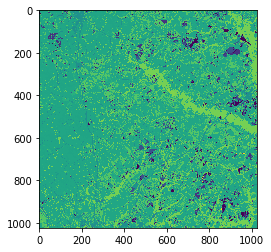

In [12]:
plt.imshow(data[1][0][0])

In [13]:
raster_layer = gps.RasterLayer.from_numpy_rdd(gps.LayerType.SPATIAL, rdd4)

In [14]:
tiled_raster_layer = raster_layer.tile_to_layout(layout = gps.GlobalLayout(), target_crs=3857)

Py4JJavaError: An error occurred while calling o114.reproject.
: org.apache.spark.SparkException: Job aborted due to stage failure: ShuffleMapStage 11 (flatMap at CutTiles.scala:48) has failed the maximum allowable number of times: 4. Most recent failure reason: org.apache.spark.shuffle.FetchFailedException: Too large frame: 2624680416
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:357)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:332)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:54)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:409)
	at scala.collection.Iterator$$anon$12.nextCur(Iterator.scala:434)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.util.CompletionIterator.hasNext(CompletionIterator.scala:32)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:39)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1336)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:504)
	at org.apache.spark.api.python.PythonRunner$WriterThread$$anonfun$run$3.apply(PythonRDD.scala:328)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1951)
	at org.apache.spark.api.python.PythonRunner$WriterThread.run(PythonRDD.scala:269)
Caused by: java.lang.IllegalArgumentException: Too large frame: 2624680416
	at org.spark_project.guava.base.Preconditions.checkArgument(Preconditions.java:119)
	at org.apache.spark.network.util.TransportFrameDecoder.decodeNext(TransportFrameDecoder.java:133)
	at org.apache.spark.network.util.TransportFrameDecoder.channelRead(TransportFrameDecoder.java:81)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:367)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:353)
	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:346)
	at io.netty.channel.DefaultChannelPipeline$HeadContext.channelRead(DefaultChannelPipeline.java:1294)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:367)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:353)
	at io.netty.channel.DefaultChannelPipeline.fireChannelRead(DefaultChannelPipeline.java:911)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:131)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:652)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:575)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:489)
	at io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:451)
	at io.netty.util.concurrent.SingleThreadEventExecutor$2.run(SingleThreadEventExecutor.java:140)
	at io.netty.util.concurrent.DefaultThreadFactory$DefaultRunnableDecorator.run(DefaultThreadFactory.java:144)
	at java.lang.Thread.run(Thread.java:748)

	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskCompletion(DAGScheduler.scala:1262)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1647)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1918)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1981)
	at org.apache.spark.rdd.RDD$$anonfun$reduce$1.apply(RDD.scala:1025)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.reduce(RDD.scala:1007)
	at geotrellis.spark.TileLayerMetadata$.collectMetadata(TileLayerMetadata.scala:122)
	at geotrellis.spark.TileLayerMetadata$.fromRdd(TileLayerMetadata.scala:185)
	at geotrellis.spark.package$withCollectMetadataMethods.collectMetadata(package.scala:186)
	at geotrellis.spark.reproject.TileRDDReproject$.apply(TileRDDReproject.scala:127)
	at geotrellis.spark.reproject.TileRDDReproject$.apply(TileRDDReproject.scala:238)
	at geotrellis.spark.reproject.TileRDDReprojectMethods.reproject(TileRDDReprojectMethods.scala:43)
	at geopyspark.geotrellis.ProjectedRasterLayer.reproject(ProjectedRasterLayer.scala:85)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
